In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [24]:
def build_dncnn(input_shape=(None, None, 1), depth=17, num_filters=64):
    inputs = layers.Input(shape=input_shape)

    # First layer (Conv + ReLU)
    x = layers.Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='glorot_uniform')(inputs)
    x = layers.Activation('relu')(x)

    # Middle layers (Conv + BatchNorm + ReLU)
    for _ in range(depth - 2):
        x = layers.Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='glorot_uniform')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

    # Final layer (Conv to predict noise)
    x = layers.Conv2D(1, (3, 3), padding='same', kernel_initializer='glorot_uniform')(x)

    # Residual Learning: Clean image = Input - Noise
    outputs = layers.Subtract()([inputs, x])

    return models.Model(inputs=inputs, outputs=outputs)

# Initialize the model
dncnn_model = build_dncnn()
dncnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, None, None, 64) │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_32             │ (None, None, None, 64) │              0 │ conv2d_34[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, None, None, 64) │         36,928 │ activation_32[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, None, None, 64) │            256 │ conv2d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_33             │ (None, None, None, 64) │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, None, None, 64) │         36,928 │ activation_33[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, None, None, 64) │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_34             │ (None, None, None, 64) │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, None, None, 64) │         36,928 │ activation_34[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, None, None, 64) │            256 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_35             │ (None, None, None, 64) │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, None, None, 64) │         36,928 │ activation_35[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, None, None, 64) │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, None, None, 64) │              0 │ batch_normalization_3… │
│ (Activation)         

 Total params: 558,977 (2.13 MB)

 Trainable params: 557,057 (2.13 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [25]:
import tensorflow as tf
import numpy as np

# Load a smaller subset of the MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Use only a subset of the data for training (e.g., first 10,000 images)
x_train, x_test = x_train[:100], x_test[:10]

# Normalize and expand dimensions for compatibility with the model
x_train = np.expand_dims(x_train / 255.0, axis=-1)  # Scale to [0, 1] and add channel dimension
x_test = np.expand_dims(x_test / 255.0, axis=-1)

# Add Gaussian noise to create noisy images
def add_gaussian_noise(images, sigma=25):
    noise = np.random.normal(0, sigma / 255.0, images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0.0, 1.0)

# Add Gaussian noise to the small subset
sigma = 25  # Set the noise level
x_train_noisy = add_gaussian_noise(x_train, sigma)
x_test_noisy = add_gaussian_noise(x_test, sigma)


In [26]:
print("Training data range:", x_train.min(), "to", x_train.max())
print("Noisy training data range:", x_train_noisy.min(), "to", x_train_noisy.max())

# Check for NaNs
print("NaNs in x_train:", np.isnan(x_train).any())
print("NaNs in x_train_noisy:", np.isnan(x_train_noisy).any())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)
dncnn_model.compile(optimizer=optimizer, loss='mse')

Training data range: 0.0 to 1.0
Noisy training data range: 0.0 to 1.0
NaNs in x_train: False
NaNs in x_train_noisy: False


Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 0.8929 - val_loss: 0.0052
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.4084 - val_loss: 0.0047
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.2706 - val_loss: 0.0045
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.1472 - val_loss: 0.0050
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0784 - val_loss: 0.0054
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0438 - val_loss: 0.0056
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0272 - val_loss: 0.0062
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0189 - val_loss: 0.0065
Epoch 9/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0144 - val_loss: 0.0071
Epoch 10/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0118 - val_loss: 0.0071
Epoch 11/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0098 - val_loss: 0.0068
Epoch 12/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0089 - val_loss: 0.0073
Epoch 13/25
3/3 ━━━

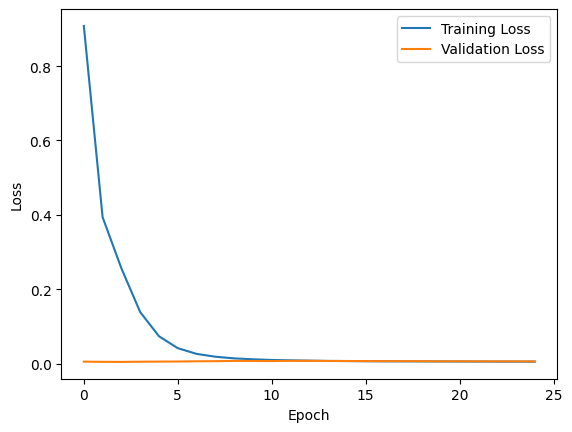

In [27]:
# Training the model
history = dncnn_model.fit(
    x_train_noisy, x_train,
    epochs=25,
    batch_size=32,
    validation_split=0.1
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
dncnn_model.save("dncnn_model.h5")

In [38]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_model(model, noisy_images, clean_images):
    # Generate denoised images
    denoised_images = model.predict(noisy_images)
    denoised_images = np.clip(denoised_images, 0.0, 1.0)  # Clip to [0, 1] range
    '''
    # Debugging: Check for NaNs and value ranges in clean, noisy, and denoised images
    print(f"NaNs in clean images: {np.isnan(clean_images).any()}")
    print(f"NaNs in noisy images: {np.isnan(noisy_images).any()}")
    print(f"NaNs in denoised images: {np.isnan(denoised_images).any()}")

    print(f"Range of clean images: {clean_images.min()} to {clean_images.max()}")
    print(f"Range of noisy images: {noisy_images.min()} to {noisy_images.max()}")
    print(f"Range of denoised images: {denoised_images.min()} to {denoised_images.max()}") '''

    psnr_scores_noisy, ssim_scores_noisy = [], []
    psnr_scores_cleaned, ssim_scores_cleaned = [], []  # denoised images

    for i in range(len(clean_images)):
        try:
            # Calculate PSNR and SSIM
            psnr = peak_signal_noise_ratio(clean_images[i].squeeze(), denoised_images[i].squeeze(), data_range=1.0)
            ssim = structural_similarity(clean_images[i].squeeze(), denoised_images[i].squeeze(), data_range=1.0)
            psnr_noisy = peak_signal_noise_ratio(clean_images[i].squeeze(), noisy_images[i].squeeze(), data_range=1.0)
            ssim_noisy = structural_similarity(clean_images[i].squeeze(), noisy_images[i].squeeze(), data_range=1.0)
            psnr_scores_noisy.append(psnr_noisy)
            ssim_scores_noisy.append(ssim_noisy)
            psnr_scores_cleaned.append(psnr)
            ssim_scores_cleaned.append(ssim)
        except ValueError as e:
            print(f"Error calculating PSNR/SSIM for image {i}: {e}")

    # Calculate the average PSNR and SSIM, ignoring any NaNs
    print(f"Average PSNR of noisy image: {np.nanmean(psnr_scores_noisy):.2f}")  # nanmean to ignore NaNs
    print(f"Average SSIM of noisy image: {np.nanmean(ssim_scores_noisy):.4f}")
    print(f"Average PSNR of denoised image: {np.nanmean(psnr_scores_cleaned):.2f}")  # nanmean to ignore NaNs
    print(f"Average SSIM of denoised image: {np.nanmean(ssim_scores_cleaned):.4f}")

# Run the evaluation
evaluate_model(dncnn_model, x_test_noisy, x_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Average PSNR of noisy image: 22.97
Average SSIM of noisy image: 0.6626
Average PSNR of denoised image: 25.07
Average SSIM of denoised image: 0.7084


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


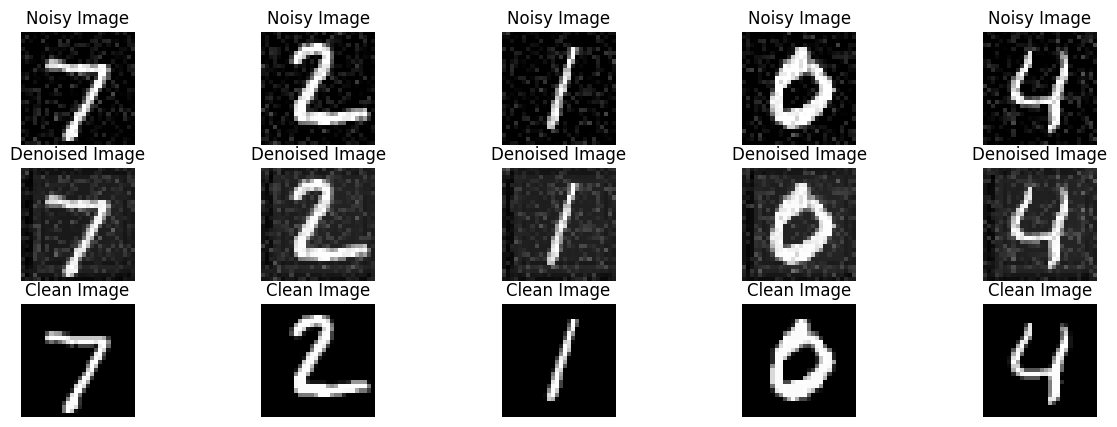

In [39]:
# Denoise some test images
num_examples = 5
denoised_images = dncnn_model.predict(x_test_noisy[:num_examples])

# Plot the results
plt.figure(figsize=(15, 5))
for i in range(num_examples):
    # Noisy image
    plt.subplot(3, num_examples, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')

    # Denoised image
    plt.subplot(3, num_examples, i + 1 + num_examples)
    plt.imshow(denoised_images[i].squeeze(), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')

    # Original clean image
    plt.subplot(3, num_examples, i + 1 + 2 * num_examples)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')

plt.show()
